Image: shape=(224, 224), dtype=uint8, min=0, max=254
Mask : shape=(224, 224), dtype=uint8, unique labels=[ 0  1  2  3  4  5  6  7  8 10 11 13]


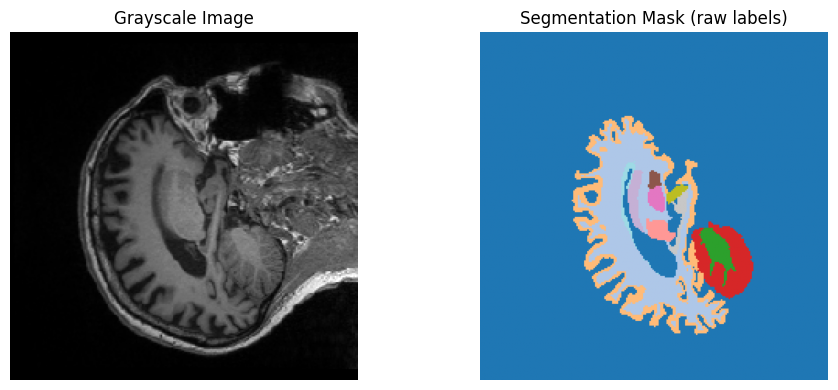

In [1]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np

def load_and_plot_png(image_png_path, mask_png_path):
    # === Load PNGs
    img = imageio.imread(image_png_path)  # shape: [H, W], dtype: uint8
    mask = imageio.imread(mask_png_path)  # shape: [H, W], dtype: uint8 (raw class indices)

    print(f"Image: shape={img.shape}, dtype={img.dtype}, min={img.min()}, max={img.max()}")
    print(f"Mask : shape={mask.shape}, dtype={mask.dtype}, unique labels={np.unique(mask)}")

    # === Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Grayscale Image")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='tab20')  # simple colormap to see labels
    axs[1].set_title("Segmentation Mask (raw labels)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# labels from 1-13 corresponding to
labels = ['Left/Right-Cerebral-White-Matter', 'Left/Right-Cerebral-Cortex',
'Left/Right-Cerebellum-White-Matter', 'Left/Right-Cerebellum-Cortex', 'Left/Right-Thalamus', 'Left/Right-Caudate',
'Left/Right-Putamen', 'Left/Right-Pallidum', 'Brain-Stem ', 'Left/Right-Hippocampus', 'Left/Right-Amygdala', 'CSF',
'WM-hypointensities']
load_and_plot_png("./demo_data/multi_segementation/img1.png", "./demo_data/multi_segementation/mask1.png")


In [2]:
from multi_seg.models_mae_finetune_seg import MaskedAutoencoderViTMultiSeg
from functools import partial
import torch
import torch.nn as nn
mode = 'mae_unet_fuse'
INPUT_SIZE = 224
# mode = 'CNN'
mae_model = MaskedAutoencoderViTMultiSeg(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), num_classes=len(labels) + 1, mode=mode,
                 drop=0.1, attn_drop=0.1, drop_path=0.05)

pretrain_path = "./saved_models/mae_vit_base_patch16_pretrain_test0.75_E30/model_E30.pt"

missing, unexpected = mae_model.load_state_dict(torch.load(pretrain_path)['model_state_dict'], strict=False)  # strict=False ignores unmatched keys

from multi_seg.mae_unet_fuse import UnetWithMAEFusion
from modeling.unet import Unet
CHANS = 64
unet_model = Unet(in_chans=3,out_chans=len(labels) + 1, chans=CHANS, if_classify= False,  dim=INPUT_SIZE, mlp_ratio = 32)

MAEFusion = UnetWithMAEFusion(unet=unet_model, mae_model=mae_model, custom_fusion_modes=['concat', 'concat', 'concat', 'concat', 'concat', 'concat', 'concat', 'concat', 'concat'], mae_indices = [0, 2, 5, 8, 11, 8, 5, 2, 0], skip_connect = True, skip_type='concat')
print(sum(p.numel() for p in MAEFusion.parameters()))
print(sum(p.numel() for p in MAEFusion.parameters() if p.requires_grad))
print(next(MAEFusion.parameters()).dtype)
MAEFusion.load_state_dict(torch.load("./finetune_models/multi_segmentation/mae_unet64concat_mae_unet_fuse_e1000_30.pt")['model_state_dict'], strict=False)

150088974
149836814
torch.float32


<All keys matched successfully>

In [3]:
# Define class color list (indexed from class 0 to 13)
# You can change these RGB values (range 0–1 or 0–255 normalized)
from matplotlib.colors import ListedColormap, BoundaryNorm
class_colors = [
    (0.0, 0.0, 0.0),       # 0: Black (Background)
    (0.6, 0.3, 0.0),       # 1: Brown
    (0.85, 0.1, 0.1),      # 2: Red
    (0.7, 0.7, 0.7),       # 3: Light Gray
    (0.0, 0.3, 0.3),       # 4: Teal-Green
    (0.5, 0.0, 0.5),       # 5: Purple
    (0.9, 0.6, 0.0),       # 6: Orange
    (0.3, 0.3, 0.3),       # 7: Dark Gray
    (0.0, 0.6, 0.0),       # 8: Dark Green
    (0.6, 0.0, 0.6),       # 9: Magenta
    (0.1, 0.1, 0.85),      # 10: Blue
    (0.9, 0.2, 0.5),       # 11: Deep Pink
    (0.2, 0.5, 0.7),       # 12: Steel Blue
    (0.9, 0.9, 0.0),       # 13: Yellow
]

# Normalize RGB values if they are in 0–255
class_colors = [(r, g, b) if max((r, g, b)) <= 1 else (r / 255, g / 255, b / 255)
                for (r, g, b) in class_colors]

custom_cmap = ListedColormap(class_colors)
custom_norm = BoundaryNorm(boundaries=np.arange(15) - 0.5, ncolors=14)
def plot_single_png_prediction(
    image_png_path, mask_png_path,
    models, model_names,
    selected_classes=None,
    device='cuda',
    save_path=None
):
    assert len(models) == len(model_names), "Each model must have a name"

    # Load image (grayscale, [H, W])
    img = imageio.imread(image_png_path).astype(np.float32) / 255.0
    mask = imageio.imread(mask_png_path).astype(np.int64)  # [H, W]

    # Prepare input tensor
    img_tensor = torch.tensor(img).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)  # [1, 3, H, W]

    # Load models to device
    for i in range(len(models)):
        models[i] = models[i].to(device)
        models[i].eval()

    # Predict
    preds_all = []
    with torch.no_grad():
        for model in models:
            logits = model(img_tensor)  # [1, C, H, W]
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()  # [H, W]
            preds_all.append(pred)

    # Prepare GT
    gt_mask = mask
    if selected_classes is not None:
        gt_mask = np.where(np.isin(gt_mask, selected_classes), gt_mask, 0)
    gt_mask_masked = np.ma.masked_where(gt_mask == 0, gt_mask)

    # === Plotting: raw + GT + N predictions
    num_cols = 2 + len(models)
    fig, axs = plt.subplots(1, num_cols, figsize=(4 * num_cols, 5))

    # Raw MRI
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Raw MRI")
    axs[0].axis('off')

    # GT overlay
    axs[1].imshow(img, cmap='gray')
    axs[1].imshow(gt_mask_masked, cmap=custom_cmap, norm=custom_norm, alpha=0.5)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    # Model predictions
    for m_idx, (pred_mask, name) in enumerate(zip(preds_all, model_names)):
        if selected_classes is not None:
            pred_mask = np.where(np.isin(pred_mask, selected_classes), pred_mask, 0)

        pred_mask_masked = np.ma.masked_where(pred_mask == 0, pred_mask)

        axs[2 + m_idx].imshow(img, cmap='gray')
        axs[2 + m_idx].imshow(pred_mask_masked, cmap=custom_cmap, norm=custom_norm, alpha=0.5)
        axs[2 + m_idx].set_title(f"{name} Prediction")
        axs[2 + m_idx].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close(fig)
        print(f"Saved to {save_path}")
    else:
        plt.show()


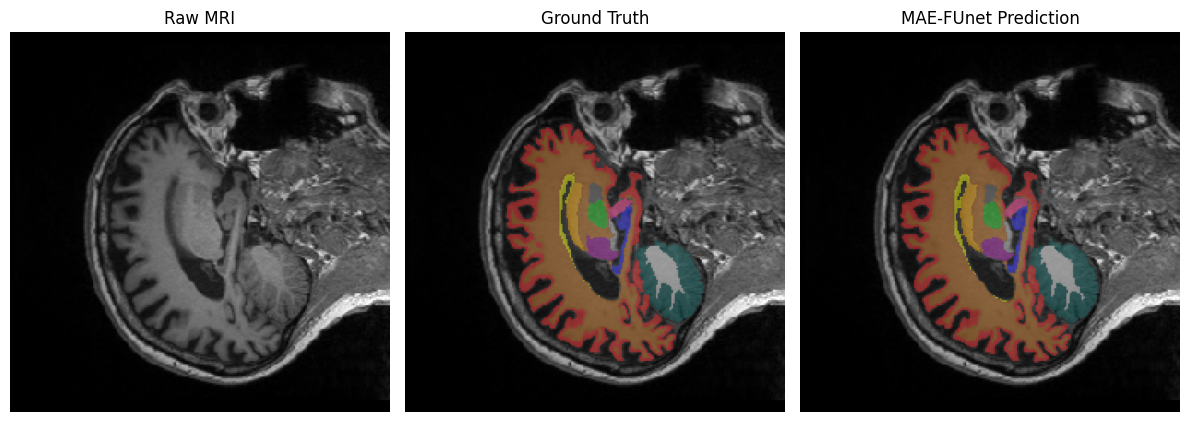

In [4]:
output_path = None
plot_single_png_prediction(
    image_png_path="./demo_data/multi_segementation/img1.png",
    mask_png_path="./demo_data/multi_segementation/mask1.png",
    models=[MAEFusion],
    model_names=["MAE-FUnet"],
    device='cuda'
)
